Features with correlation coefficient with price > than 0.25
Columns that will be used for the training:
 ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront', 'floors'] 

🔹 Test size 40%:
  Training set size: 12967 | Test set size: 8646


c:\Users\Arturo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


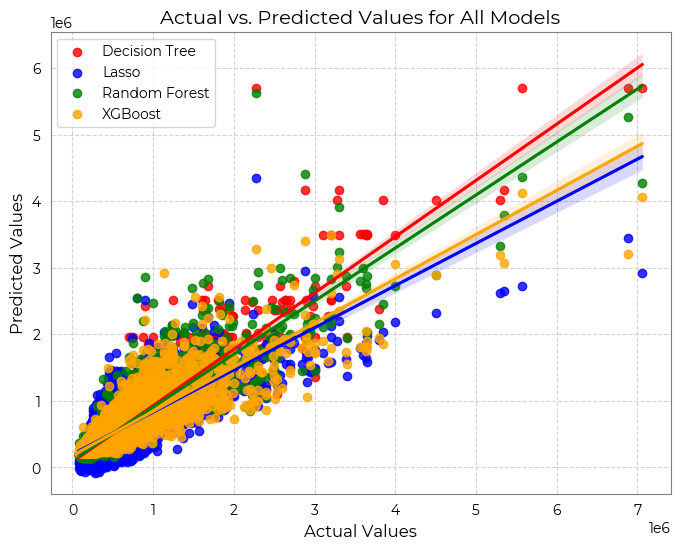

In [32]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scp.decision_tree as dt
from sklearn.preprocessing import StandardScaler

# Load dataset and prepare test data
assets = pd.read_csv("dataset/king_country_houses_aa.csv")
df = assets.copy()
correlated_columns = dt.selecting_features(df, corr_coef=0.25)
X_train, X_test, y_train, y_test = dt.select_training_set(df, correlated_columns, test_size=0.4)

# Path to models folder
models_folder = "./models"

# List of pickle files
model_files = [f for f in os.listdir(models_folder) if f.endswith(".pkl")]

# Define colors (extend dynamically)
base_colors = ["red", "blue", "green", "purple", "orange", "olive"]
colors = base_colors * (len(model_files) // len(base_colors) + 1)

plt.figure(figsize=(8, 6))

# Loop through models
for i, model_file in enumerate(model_files):

    if (model_file == "ridge_model.pkl"):
        continue

    with open(os.path.join(models_folder, model_file), "rb") as f:
        model = pickle.load(f)

    # Get model's expected features
    if hasattr(model, "feature_names_in_"):  
        model_features = model.feature_names_in_
    else:
        model_features = X_test.columns  


    # Align X_test with model's expected features

    # Ensure model's expected features are correctly assigned
    expected_features = model.feature_names_in_ if hasattr(model, "feature_names_in_") else X_test.columns[:model.n_features_in_]

    # Reindex X_test_aligned to match model's features and fill missing ones with 0
    X_test_aligned = X_test.reindex(columns=expected_features, fill_value=0)

    # Check for the correct number of columns and make sure the feature names match

    if model_file == "lasso_model.pkl":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reindex(columns=expected_features, fill_value=0))
        X_test_scaled = scaler.transform(X_test_aligned)
        # Predict
        y_pred = model.predict(X_test_scaled) 
    else:
        y_pred = model.predict(X_test_aligned.values)

    # Plot regression
    sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": colors[i]}, line_kws={"color": colors[i]}, label=model_file.replace("_model.pkl", "").replace("_", " ").title().replace("Xgb", "XGB"))

# Customize appearance
plt.xlabel("Actual Values", fontsize=12, color="black")
plt.ylabel("Predicted Values", fontsize=12, color="black")
plt.title("Actual vs. Predicted Values for All Models", fontsize=14)
plt.legend()

# Remove background and grid
plt.gca().set_facecolor("white")
plt.grid(True, color="lightgrey", linestyle="--")
plt.xticks(color="black")
plt.yticks(color="black")


# Save figure
plt.savefig("images/all_models_regression_plot.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
def plot_model_metrics(metrics_dict, save_path="model_comparison.png"):
    # Convert dictionary to DataFrame
    df = pd.DataFrame(metrics_dict)

    # Define bar positions
    metrics = ['R²', 'MAE', 'RMSE']
    x = np.arange(len(metrics))  # Label locations
    width = 0.2  # Width of bars
    
    # Define colors
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot each model's metrics
    for i, (model_name, values) in enumerate(df.items()):
        ax.bar(x + i * width, values, width, label=model_name, color=colors[i % len(colors)])
    
    # Format plot
    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title("Model Comparison")
    ax.set_xticks(x + (width * (len(metrics_dict) - 1)) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Remove background
    fig.patch.set_alpha(0)
    ax.set_facecolor('white')

    # Save the plot without a background
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

# Example usage
model_metrics = {
    "Decision Tree": [0.85, 5000, 7000],   # [R², MAE, RMSE]
    "Random Forest": [0.88, 4500, 6500],
    "Lasso": [0.75, 6000, 8000]
}

plot_model_metrics(model_metrics)